In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader
from torchvision import transforms as T

from tqdm.notebook import tqdm

transform_augmented = T.Compose([
    T.ToTensor(),
    T.ConvertImageDtype(torch.uint8),
    T.RandAugment(),
    T.ConvertImageDtype(torch.float),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transform_val = T.Compose([
    T.ToTensor(),
#     T.ConvertImageDtype(torch.uint8),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(2022)

In [2]:
%%time
data = pd.read_pickle('./annotation_pandas.pickle')
# Filter some trash
data = data[data['image'].apply(lambda item: item.shape) == (98, 67, 3)]

output_genres = data['genre'].nunique()
images = data['image'].tolist()
genre_to_key = {name: key for key, name in enumerate(np.sort(data['genre'].unique()))}
key_to_genre = dict(zip(genre_to_key.values(), genre_to_key.keys()))
# labels = data['genre'].map(mapping_genre).tolist()
labels = pd.get_dummies(data['genre']).values

random_indices = np.random.choice(np.arange(len(images)), size=200, replace=False)

images_val = [item for idx, item in enumerate(images) if idx in random_indices]
labels_val = [item for idx, item in enumerate(labels) if idx in random_indices]
images_train = [item for idx, item in enumerate(images) if idx not in random_indices]
labels_train = [item for idx, item in enumerate(labels) if idx not in random_indices]

images_val = [transform_val(image) for image in images_val]
labels_val = [label for label in labels_val]

images_train += 4 * images_train
labels_train += 4 * labels_train
images_train = [transform_augmented(image) for image in images_train]
labels_train = [label for label in labels_train]

loader_val = DataLoader(list(zip(images_val, labels_val)), batch_size=512, shuffle=True)
loader_train = DataLoader(list(zip(images_train, labels_train)), batch_size=512, shuffle=True)

CPU times: total: 4min 29s
Wall time: 34 s


In [3]:
images_train[0].shape, output_genres

(torch.Size([3, 98, 67]), 24)

In [4]:
class AutoEncoder(nn.Module):
    
    def __init__(self, output_classes: int):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2, return_indices=True),
        )
        
        self.encoder_linear = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(4480, 1028),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1028, 512),
            nn.ReLU(),
            nn.Linear(512, output_classes),
        )
        
        self.decoder_linear = nn.Sequential(
            nn.Linear(output_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 1028),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1028, 4480),
            nn.Unflatten(1, (64, 10, 7)),
        )
        
        self.unpool = nn.MaxUnpool2d(2)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.ConvTranspose2d(16, 3, 3, 2),
        )
                    
    def encode(self, x):
        x, indices = self.encoder(x)
#         x = self.encoder(x)
#         print(x.shape)
        x = self.encoder_linear(x)
        x = F.softmax(x, dim=1)
        return x, indices
        
    def decode(self, x, indices):
        x = self.decoder_linear(x)
        x = self.unpool(x, indices, output_size=(x.shape[0], 64, 21, 14))
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        encoded, indices = self.encode(x)
        decoded = self.decode(encoded, indices)
        return encoded, decoded

In [5]:
24 * 10 * 7

1680

In [6]:
for im, lb in loader_train:
    break
im.shape, lb.shape

(torch.Size([512, 3, 98, 67]), torch.Size([512, 24]))

In [7]:
model = AutoEncoder(output_genres)
encoded, decoded = model(im)
nn.MSELoss()(decoded, im[:, :, 1 : -2]), nn.CrossEntropyLoss()(encoded, lb.to(torch.float))

(tensor(2.2155, grad_fn=<MseLossBackward0>),
 tensor(3.1781, grad_fn=<DivBackward1>))

In [8]:
model = AutoEncoder(output_genres).to(device)
mse_loss_function = nn.MSELoss().to(device)
cls_loss_function = nn.CrossEntropyLoss().to(device)

losses_train = []
losses_test = []

In [9]:
from torchviz import make_dot

batch = next(iter(loader_train))
yhat = model(batch[0].to(device))

make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 60

mse_multp = 1
cls_multp = 0

for epoch in tqdm(range(epochs)):
    model.train()
    loss_train = 0
    for batch_idx, (inputs, targets) in enumerate(loader_train, start=1):
        inputs, targets = inputs.to(device), targets.to(device).to(torch.float)
        optimizer.zero_grad()
        encoded, decoded = model(inputs)
        cls_loss = cls_loss_function(encoded, targets)
        mse_loss = mse_loss_function(decoded, inputs[:, :, 1:-2])
        loss = (mse_multp * mse_loss) + (cls_multp * cls_loss)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    losses_train.append(loss_train / batch_idx)
    
    model.eval()
    loss_val = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader_val, start=1):
            inputs, targets = inputs.to(device), targets.to(device).to(torch.float)
            encoded, decoded = model(inputs)
            cls_loss = cls_loss_function(encoded, targets)
            mse_loss = mse_loss_function(decoded, inputs[:, :, 1:-2])
            loss_val += ((mse_multp * mse_loss) + (cls_multp * cls_loss)).item()

    losses_test.append(loss_val / batch_idx)

    print(f'epoch {epoch}/{epochs}; train_loss:{losses_train[-1]:.2f}, val_loss:{losses_test[-1]:.2f}')

  0%|          | 0/60 [00:00<?, ?it/s]

epoch 0/60; train_loss:1.88, val_loss:1.43
epoch 1/60; train_loss:1.25, val_loss:1.10
epoch 2/60; train_loss:1.05, val_loss:0.93
epoch 3/60; train_loss:0.92, val_loss:0.85
epoch 4/60; train_loss:0.86, val_loss:0.81
epoch 5/60; train_loss:0.83, val_loss:0.80
epoch 6/60; train_loss:0.80, val_loss:0.78
epoch 7/60; train_loss:0.78, val_loss:0.77
epoch 8/60; train_loss:0.77, val_loss:0.76
epoch 9/60; train_loss:0.76, val_loss:0.75
epoch 10/60; train_loss:0.75, val_loss:0.74
epoch 11/60; train_loss:0.75, val_loss:0.74
epoch 12/60; train_loss:0.74, val_loss:0.73
epoch 13/60; train_loss:0.73, val_loss:0.73
epoch 14/60; train_loss:0.72, val_loss:0.72
epoch 15/60; train_loss:0.71, val_loss:0.69
epoch 16/60; train_loss:0.69, val_loss:0.67
epoch 17/60; train_loss:0.68, val_loss:0.64
epoch 18/60; train_loss:0.66, val_loss:0.64
epoch 19/60; train_loss:0.66, val_loss:0.63
epoch 20/60; train_loss:0.65, val_loss:0.62
epoch 21/60; train_loss:0.65, val_loss:0.62
epoch 22/60; train_loss:0.64, val_loss:0.6

In [14]:
input_logits = torch.rand(output_genres)
decoded, encoded = model(loader_val.dataset[0][0].to(device)[None, :])
generated_image = encoded.cpu().detach().numpy()

In [15]:
generated_image.shape

(1, 3, 95, 67)

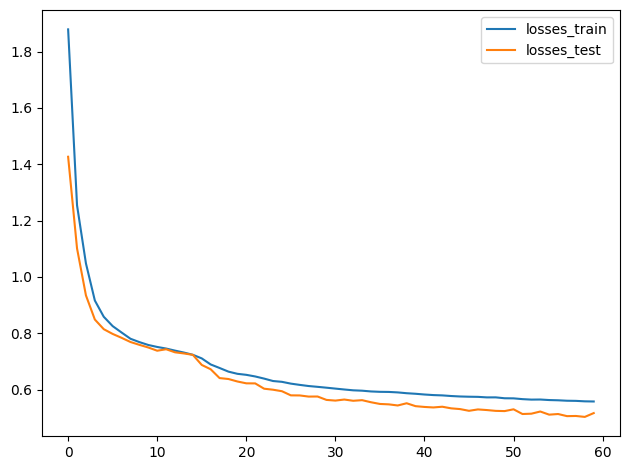

In [11]:
fig, ax = plt.subplots()

ax.plot(losses_train, label='losses_train')
ax.plot(losses_test, label='losses_test')
ax.legend()
fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


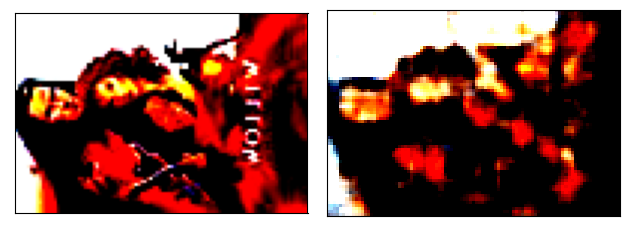

In [22]:
idx = 4
img = loader_val.dataset[idx][0].to(device)[None, :]
encoded, decoded = model(img)
generated_image = decoded.cpu().detach().numpy()

fig, axes = plt.subplots(ncols=2)

axes[1].imshow(generated_image[0].T)
axes[0].imshow(img[0].cpu().detach().numpy().T)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [13]:
im.shape

torch.Size([512, 3, 98, 67])

In [14]:
loader_val.dataset[0][1]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=uint8)

In [15]:
(outputs).cpu().detach().numpy().round(3)

NameError: name 'outputs' is not defined

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
tensor([[0.0516, 0.0407, 0.0266, 0.0287, 0.0367, 0.0707, 0.0557, 0.0711, 0.0353,
         0.0519, 0.0226, 0.0757, 0.0282, 0.0227, 0.0413, 0.0354, 0.0467, 0.0211,
         0.0539, 0.0201, 0.0435, 0.0408, 0.0295, 0.0494]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


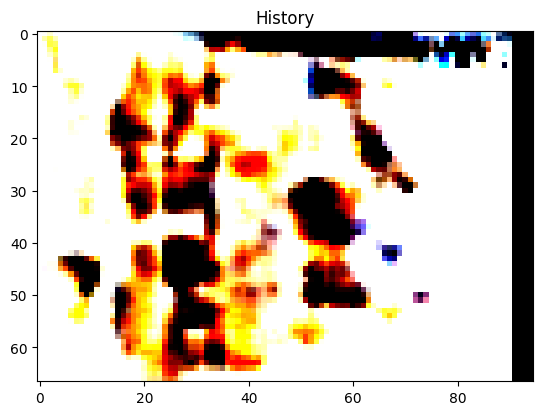

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


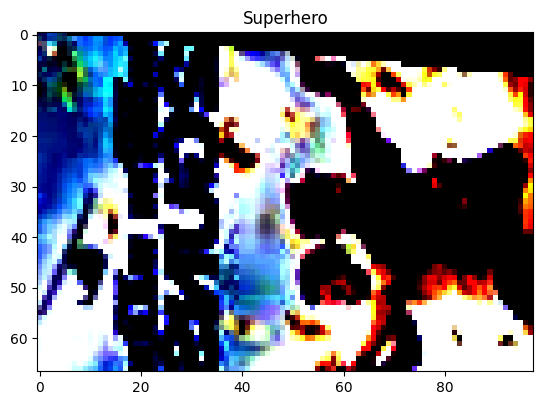

In [20]:
im, lb = loader_train.dataset[-34]
print(lb)
outputs, indices = model.encode(im[None, :].to(device))
print(outputs)
random_image = model.decode(torch.Tensor(lb)[None, :].to(device), indices).cpu().detach().numpy()[0]

plt.title(f'{key_to_genre[outputs.argmax().item()]}')
plt.imshow(random_image.T)
plt.show()
plt.title(key_to_genre[lb.argmax()])
plt.imshow(im.numpy().T)

## save model

In [17]:
torch.save(model.state_dict(), './models/cnnAE.config')

In [18]:
class AEModel:
    
    _output_genres: int = 24
    _model: nn.Module = AutoEncoder(output_genres)
    _transform_val = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    def __init__(self, path: str):
        self._model.load_state_dict(torch.load(path))
        self._model.eval()
        
    def get_features(self, image: np.ndarray) -> np.ndarray:
        image = self._transform_val(image)[None, :]
        outputs, _ = self._model(image)
        return outputs.detach().numpy().squeeze()

In [19]:
aemodel = AEModel('./models/cnnAE.config')

In [106]:
aemodel.get_features(data.iloc[0]['image'])

array([9.9936098e-01, 9.4089519e-06, 5.4662964e-06, 4.5877463e-05,
       1.3549278e-05, 1.2002495e-07, 2.0112930e-06, 5.7209204e-06,
       9.1048427e-08, 8.1671700e-05, 5.5417844e-05, 3.9000344e-04,
       1.6479484e-10, 9.9119788e-09, 1.7419076e-06, 2.6998338e-08,
       1.5592573e-06, 1.7299316e-08, 2.0309659e-05, 4.5499369e-06,
       3.7676470e-10, 5.3974155e-08, 1.2612506e-06, 1.3377918e-09],
      dtype=float32)

In [108]:
data.iloc[0]

id                                                     tt1016150
name                                      Im Westen nichts Neues
year                                                      2022.0
url            https://www.imdb.com/title/tt1016150/?ref_=adv...
poster         https://m.media-amazon.com/images/M/MV5BYTE1Mm...
genre                                                     Action
description    A young German soldier&apos;s terrifying exper...
image          [[[75, 102, 113], [85, 112, 123], [87, 114, 12...
Name: 0, dtype: object

In [ ]:
key_to_genre